In [6]:
import keras
import numpy as np
from   scipy.stats  import normaltest
from   sklearn.base import BaseEstimator
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import *
from   sklearn.datasets        import make_classification

2024-03-17 15:31:44.030453: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 15:31:44.252436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 15:31:44.252504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 15:31:44.268553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 15:31:44.309447: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 15:31:44.309929: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Inicialização de Glorol 

In [7]:
fan_in  = 3 # numero de neuronios da camanda de entrada
fan_out = 2 # numero de neuronios da camanda de saida

In [8]:
from typing import Literal
class Inicializate(BaseEstimator):
    def __init__(self, fan_in:int, fan_out:int, activation:Literal['relu','selu','glorot']='relu'):
        self.fan_in  = fan_in
        self.fan_out = fan_out
        self.activation = activation

    def normal(self, size=1):
        match (self.activation):
            case 'relu':
                return np.random.normal(loc=0, scale=2/self.fan_in, size=size)
            case 'selu':
                return np.random.normal(loc=0, scale=1/self.fan_in, size=size)
            case 'glorot':
                return np.random.normal(loc=0, scale=1/np.average([self.fan_in,self.fan_out]), size=size)


In [9]:
ini = Inicializate(fan_in=2, fan_out=2, activation='glorot')
display(ini)
ini.normal(2).reshape(2,1)

Inicializate(activation='glorot', fan_in=2, fan_out=2)

array([[-0.22332035],
       [-0.3170818 ]])

In [10]:
int = keras.initializers.VarianceScaling(scale=1, distribution='normal', mode='fan_avg')
int(shape=(2,1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.4674049 ],
       [-0.40712443]], dtype=float32)>

## Funções de ativação sem saturação

In [11]:
X, y = make_classification(random_state=42, n_samples=3000, n_clusters_per_class=2, class_sep=0.75)

xtrainF, xtestF, ytrainF, ytestF = train_test_split(X, y, random_state=42 ,test_size=0.25)

xtrain, xvalid , ytrain , yvalid = train_test_split(xtrainF, ytrainF, random_state=42, test_size=0.25)

In [12]:
def Model(activation='relu'):
    input_ = keras.layers.Input(shape=xtrain.shape[1:], name='camada entrada')
    hidden_1 = keras.layers.Dense(units=35, activation=activation, name='camada_inferior')(input_)
    hidden_2 = keras.layers.Dense(units=25, activation=activation, name='camada_oculta1')(hidden_1)
    hidden_3 = keras.layers.Dense(units=20, activation=activation, name='camada_media')(hidden_2)
    hidden_4 = keras.layers.Dense(units=15, activation=activation, name='camada_oculta2')(hidden_3)
    hidden_5 = keras.layers.Dense(units=10,  activation=activation, name='camada_superior')(hidden_4)
    output_  = keras.layers.Dense(units=1,  activation=activation, name='saida')(hidden_5)
    return keras.models.Model( inputs=[input_], outputs=[output_] )


In [13]:
model1 = Model('relu')
model1.compile(
    optimizer = keras.optimizers.Adam(),
    loss      = keras.losses.binary_crossentropy,
    metrics   = [keras.metrics.binary_accuracy]
)
#earlyStopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history1 = model1.fit(xtrain, ytrain, epochs=10 ,batch_size=10, validation_data=(xvalid,yvalid), verbose=0)

In [14]:
model2 = Model('elu')
model2.compile(
    optimizer = keras.optimizers.Adam(),
    loss      = keras.losses.binary_crossentropy,
    metrics   = [keras.metrics.binary_accuracy]
)
#earlyStopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history2 = model2.fit(xtrain, ytrain, epochs=10 ,batch_size=10, validation_data=(xvalid,yvalid),verbose=0)

In [15]:
model3 = Model(keras.activations.selu)
model3.compile(
    optimizer = keras.optimizers.Adam(),
    loss      = keras.losses.binary_crossentropy,
    metrics   = [keras.metrics.binary_accuracy]
)
#earlyStopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history3 = model3.fit(xtrain, ytrain, epochs=10 ,batch_size=10, validation_data=(xvalid,yvalid),verbose=0)

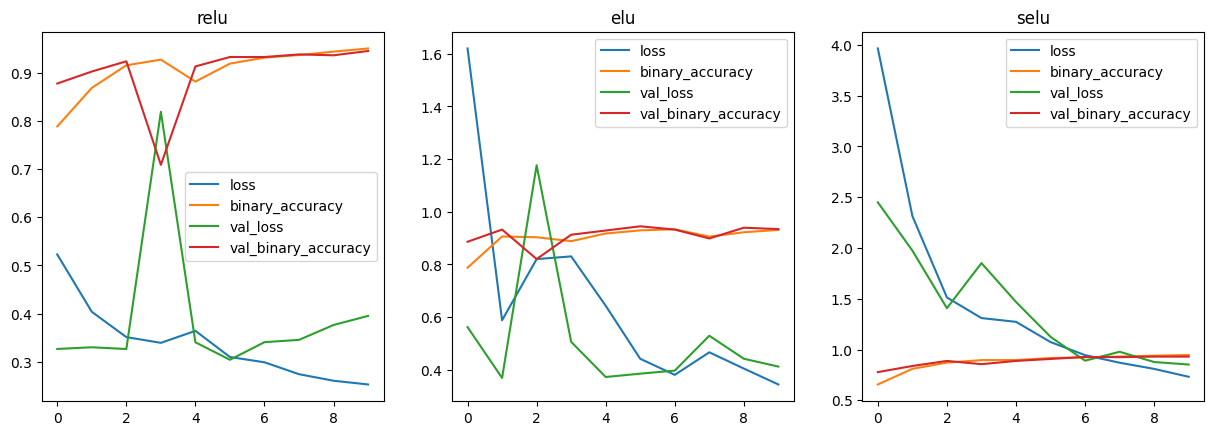

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,3)
fig.set_figwidth(15)
pd.DataFrame(history1.history).plot(ax=ax[0],title='relu')
pd.DataFrame(history2.history).plot(ax=ax[1],title='elu')
pd.DataFrame(history3.history).plot(ax=ax[2],title='selu')

plt.show()

In [17]:
print(classification_report(ytestF,model1.predict(xtestF)>0.5))

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       371
           1       0.91      0.95      0.93       379

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750



In [18]:
print(classification_report(ytestF,model2.predict(xtestF)>0.5))

24/24 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       371
           1       0.92      0.91      0.92       379

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750



In [19]:
print(classification_report(ytestF,model3.predict(xtestF)>0.5))

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       371
           1       0.90      0.96      0.93       379

    accuracy                           0.92       750
   macro avg       0.93      0.92      0.92       750
weighted avg       0.93      0.92      0.92       750



In [20]:
confusion_matrix(ytestF,model3.predict(xtestF)>0.5)

24/24 [==============================] - 0s 2ms/step


array([[331,  40],
       [ 17, 362]])

## Elu

In [21]:
def elu(z):
    return np.where(z < 0, 1*(np.exp(z)-1), z )

In [22]:
z=np.linspace(-3,3,20)

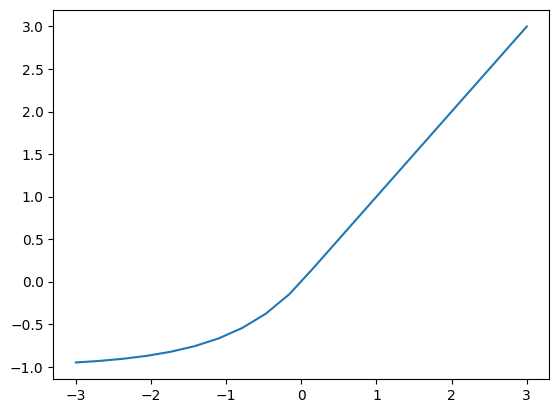

In [23]:
plt.plot(z,elu(z))

## Batch Normalização

In [26]:
def Model(activation=keras.activations.selu):
    model = keras.models.Sequential(
        layers=[
            keras.layers.Dense(units=35, activation=activation, name='camada_inferior'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(units=25, activation=activation, name='camada_oculta1'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(units=20, activation=activation, name='camada_media'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(units=15, activation=activation, name='camada_oculta2'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(units=10,  activation=activation, name='camada_superior'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(units=1,  activation=activation, name='saida')
        ]
    )

    return model


In [29]:
model = Model()
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss      = keras.losses.binary_crossentropy,
    metrics   = [keras.metrics.binary_accuracy]
)
keras.callbacks.EarlyStopping()
history = model.fit(xtrain , ytrain, batch_size=20, epochs=20, validation_data=(xvalid,yvalid))

Epoch 1/20
85/85 [==============================] - 3s 10ms/step - loss: 2.4917 - binary_accuracy: 0.7048 - val_loss: 1.0514 - val_binary_accuracy: 0.8490
Epoch 2/20
85/85 [==============================] - 0s 5ms/step - loss: 0.9753 - binary_accuracy: 0.8429 - val_loss: 0.9202 - val_binary_accuracy: 0.8774
Epoch 3/20
85/85 [==============================] - 0s 6ms/step - loss: 0.9032 - binary_accuracy: 0.8654 - val_loss: 0.7262 - val_binary_accuracy: 0.8970
Epoch 4/20
85/85 [==============================] - 0s 6ms/step - loss: 0.7589 - binary_accuracy: 0.8826 - val_loss: 0.5962 - val_binary_accuracy: 0.9236
Epoch 5/20
85/85 [==============================] - 0s 5ms/step - loss: 0.7415 - binary_accuracy: 0.8903 - val_loss: 0.6514 - val_binary_accuracy: 0.8952
Epoch 6/20
85/85 [==============================] - 1s 6ms/step - loss: 0.6891 - binary_accuracy: 0.8909 - val_loss: 0.5638 - val_binary_accuracy: 0.9130
Epoch 7/20
85/85 [==============================] - 0s 6ms/step - loss: 2.1

In [33]:
pred = model.predict(xtestF)>0.5

24/24 [==============================] - 0s 2ms/step


In [36]:
print(classification_report(pred,ytestF))

              precision    recall  f1-score   support

       False       0.90      0.94      0.92       356
        True       0.94      0.90      0.92       394

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750

